#1er Curso de Inteligencia Artificial aplicada a pesquerías API-INIDEP - 2023

Docentes

Gustavo Javier MESCHINO

Diego Sebastián COMAS

Matías YERRO

### Redes neuronales - Clasificación - MNIST

21/11/23

Comenzamos entonces con las primeras redes neuronales. Se incluyen aquí funciones que le serán de utilidad para comenzar el estudio.

In [1]:
#Bloque de imports:

import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.datasets import mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

plt.rcParams['figure.figsize'] = [3, 3]

In [2]:
#Bloque de funciones:


# Cargar MNIST y dividir en train / test
def cargar_dataset():
	# Carga MNIST
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# Reestructurar a un solo canal
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# Clasificación de target en one-hot
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

# Normalización de tonos de pixel
def prep_pixels(train, test):
	# Transformar integers en floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# Normalizar 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# Devolver normalizado
	return train_norm, test_norm

# Graficar un dígito
def graficar_uno(valor, conjunto, prediccion=None):
	fig = plt.figure
	plt.imshow(conjunto[valor], cmap='gray_r')
	if np.array_equiv(conjunto, trainX):
		plt.xlabel('Label train: {}'.format(np.argmax(trainY[valor])))
	if np.array_equiv(conjunto, testX):
		plt.xlabel('Label test: {}'.format(np.argmax(testY[valor])))
	if prediccion is not None:
		plt.ylabel('Predicho: '+str(prediccion))
	return plt.show()

In [3]:
#Esta función permite graficar las matrices de confusión de manera agradable a la vista

def plot_confusion_matrix(y_true, y_pred, classes=np.arange(10),
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Purples):
    if not title:
        if normalize:
            title = 'Matriz de confusión normalizada'
        else:
            title = 'Matriz de confusión sin normalizar'
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Matriz de confusión normalizada')
    else:
        print('Matriz de confusión sin normalizar')
    print(cm)
    fig, ax = plt.subplots(figsize=(10, 7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Cifra predicha',
           xlabel='Cifra verdadera')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=3)

In [4]:
# Evaluador SIMPLE

def evaluar_modelo_simple(dataX,dataY,modelo,estadoaleatorio=1,epocas=10):
	scores, histories= list(),list()
	model = modelo()
	history = model.fit(trainX, trainY, epochs=epocas, batch_size=32, validation_data=(testX, testY), verbose=1)
	_, acc = model.evaluate(testX, testY, verbose=1)
	print('> %.3f' % (acc * 100.0))
	scores.append(acc)
	histories.append(history)
	return scores, histories, model

# Evaluación con k-fold cross-validation
def evaluar_modelo_kfold(dataX, dataY, modelo, n_folds=5, estadoaleatorio=1):
	scores, histories = list(), list()
	# preparar los k-fold
	kfold = KFold(n_folds, shuffle=True, random_state=estadoaleatorio)
	# Enumerar las divisiones
	for train_ix, test_ix in kfold.split(dataX):
		# definir model
		model = modelo()
		# elegir filas para train y validation
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fitear modelo
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluar modelo
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# guardar puntajes
		scores.append(acc)
		histories.append(history)
	return scores, histories, model

# Graficar diagnósticos
def diagnosticos(histories):
	for i in range(len(histories)):
		# graficar loss
		plt.subplot(2, 1, 1)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# graficar accuracy
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	plt.show()

In [5]:
trainX, trainY, testX, testY = cargar_dataset()
trainX, testX = prep_pixels(trainX, testX)

11490434/11490434 [==============================] - 0s 0us/step


In [6]:
def predecirparaunalista(redneuronalentrenada,conjunto=testX):
    puntajes = redneuronalentrenada.predict(conjunto)
    prediccion =np.zeros(len(conjunto),dtype=int)
    for x in range(1,len(conjunto)):
        prediccion[x] = np.argmax(puntajes[x])
    unique, counts = np.unique(prediccion,return_counts=True)
    return dict(zip(unique,counts))


In [7]:
def matrizdeconfusion(redneuronalentrenada,conjunto=testX, targetsonehot=testY, normalizar=False):
    puntajes = redneuronalentrenada.predict(conjunto)
    prediccion =np.zeros(len(conjunto),dtype=int)
    for x in range(1,len(conjunto)):
        prediccion[x] = np.argmax(puntajes[x])
    plot_confusion_matrix(prediccion, np.argmax(targetsonehot, axis= 1), normalize=normalizar, title= "Matriz de confusión")
    plt.show()

In [8]:
def find_non_equal_indices(list1, list2):
    non_equal_indices = []
    for i in range(min(len(list1), len(list2))):
        if list1[i] != list2[i]:
            non_equal_indices.append(i)
    return non_equal_indices

def listarerrores(adivinado,objetivo=testY):
    errores = find_non_equal_indices(adivinado,np.argmax(objetivo, axis = 1))
    return errores

 El MNIST es un conjunto de imágenes de digitos del 0 al 9 escritos a mano. Este dataset tiene mas de 60,000 imágenes separadas en 10 clases. El reto es construir un clasificador de imágenes que sea capaz de reconocer los digitos.

In [9]:
print ("Tamaño de conjunto de entrenamiento: "+str(len(trainX)) + "\n"+"Tamaño de conjunto de test:          "+str(len(testX)))

Tamaño de conjunto de entrenamiento: 60000
Tamaño de conjunto de test:          10000


In [10]:
plt.rcParams['figure.figsize'] = [3, 3]

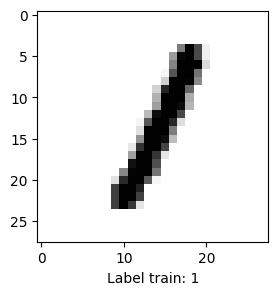

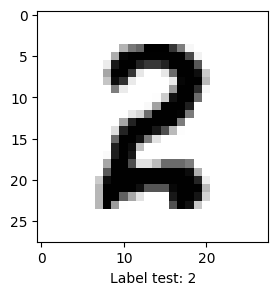

In [11]:
graficar_uno(315, trainX)
graficar_uno(5626, testX)

# Redes neuronales? Redes neuronales!

### Comencemos entonces de la manera más simple que podamos:

In [12]:
def red_simple():
	model = Sequential() # keras. Agrupa un conjunto de layers dentro de un modelo
	model.add(Flatten()) # Las imágenes son de 28x28, matriciales. Necesitamos achatarlas i.e. 28x28 -> 784 entradas!
	model.add(Dense(1, activation="sigmoid")) # UNA capa oculta con una sola neuronita. Activación más básica que encontramos: Sigmoide.
	model.add(Dense(10, activation='softmax')) # Estamos armando un clasificador... la capa de salida debe ser softmax
	opt = keras.optimizers.SGD(learning_rate=0.01) # Descenso por gradiente. El optimizador más simple
	model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy']) #Compilamos las capas secuenciales.
	#                                                                             Como es clasificación, nuestra medida de error es entropía cruzada
    #                                                                             A la vez, queremos que reporte el accuracy
	return model

In [13]:
scores, histories, entrenado = evaluar_modelo_simple(trainX, trainY, red_simple)
#scores, histories, entrenado = evaluar_modelo_kfold(trainX, trainY, red_simple)

Epoch 1/10
1875/1875 [==============================] - 15s 8ms/step - loss: 2.2499 - accuracy: 0.1654 - val_loss: 2.1925 - val_accuracy: 0.2087
Epoch 2/10
1875/1875 [==============================] - 14s 7ms/step - loss: 2.1499 - accuracy: 0.2091 - val_loss: 2.1053 - val_accuracy: 0.2143
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 2.0745 - accuracy: 0.2148 - val_loss: 2.0406 - val_accuracy: 0.2197
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 2.0190 - accuracy: 0.2194 - val_loss: 1.9936 - val_accuracy: 0.2222
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 1.9784 - accuracy: 0.2217 - val_loss: 1.9587 - val_accuracy: 0.2262
Epoch 6/10
1875/1875 [==============================] - 5s 2ms/step - loss: 1.9477 - accuracy: 0.2265 - val_loss: 1.9315 - val_accuracy: 0.2310
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 1.9236 - accuracy: 0.2301 - val_loss: 1.9100 - val_accurac

Accuracy en validación: ~23% ±2... Le pega casi a un cuarto de los targets, nada mal para una neuronita sola no?

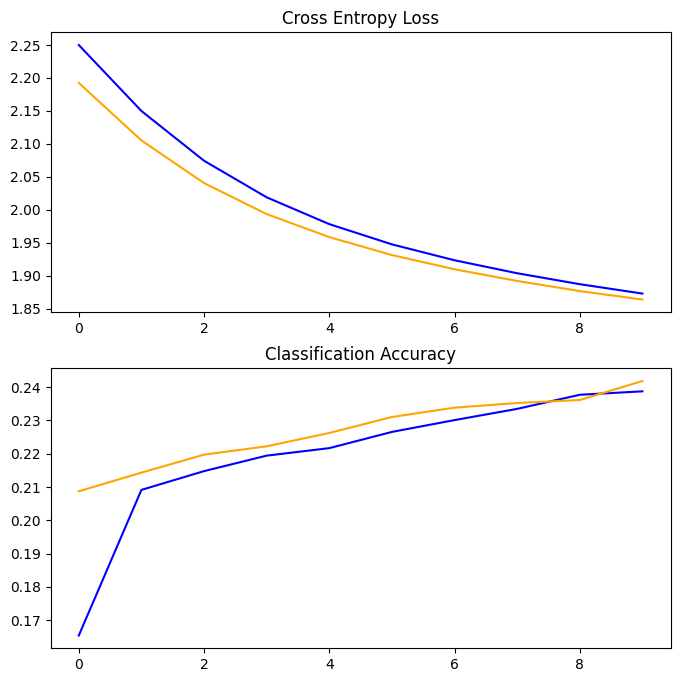

In [14]:
# Grafiquemos cómo fue entrenando:

plt.rcParams['figure.figsize'] = [8, 8]
diagnosticos(histories)

¿Dónde se confundió la red? Podemos hacer la matriz de confusión....

313/313 [==============================] - 1s 1ms/step
Matriz de confusión normalizada
[[0.238 0.001 0.026 0.021 0.145 0.181 0.236 0.002 0.142 0.009]
 [0.001 0.271 0.138 0.126 0.012 0.01  0.001 0.238 0.03  0.173]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [0.011 0.016 0.226 0.241 0.089 0.054 0.011 0.032 0.128 0.192]
 [0.062 0.    0.139 0.155 0.247 0.072 0.062 0.005 0.216 0.041]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [0.044 0.007 0.108 0.115 0.38  0.102 0.024 0.003 0.166 0.051]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [0.024 0.    0.14  0.195 0.234 0.105 0.019 0.024 0.165 0.094]
 [0.015 0.03  0.286 0.263 0.06  0.008 0.    0.023 0.09  0.226]]


<ipython-input-3-158d7bd477a4>:15: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


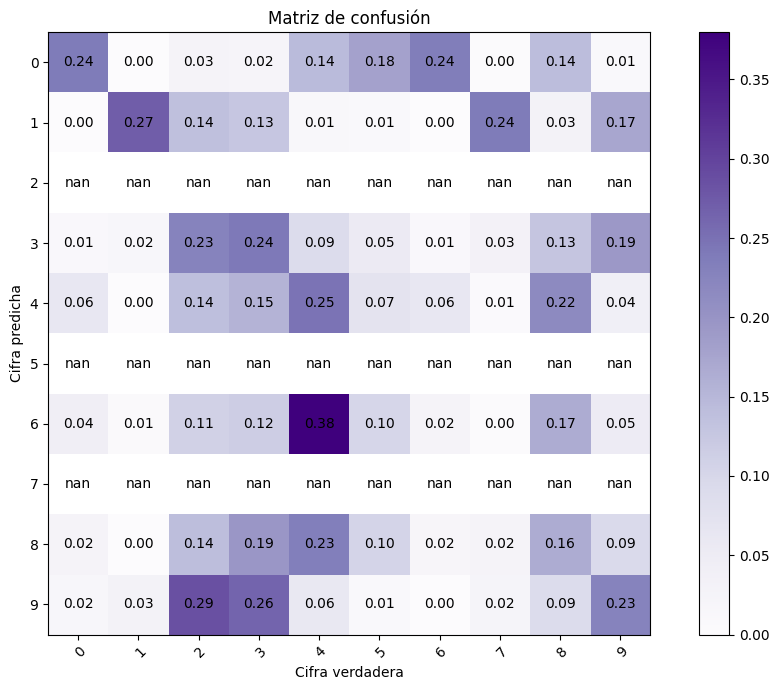

In [15]:
matrizdeconfusion(entrenado,normalizar=True)

In [16]:
#Por si queremos evaluar post training:
#entrenado.evaluate(testX,testY)

Y si entrenamos más épocas?

Epoch 1/50
1875/1875 [==============================] - 4s 2ms/step - loss: 2.2775 - accuracy: 0.1447 - val_loss: 2.2475 - val_accuracy: 0.2100
Epoch 2/50
1875/1875 [==============================] - 4s 2ms/step - loss: 2.2078 - accuracy: 0.2448 - val_loss: 2.1633 - val_accuracy: 0.2582
Epoch 3/50
1875/1875 [==============================] - 5s 3ms/step - loss: 2.1237 - accuracy: 0.2403 - val_loss: 2.0846 - val_accuracy: 0.2327
Epoch 4/50
1875/1875 [==============================] - 4s 2ms/step - loss: 2.0564 - accuracy: 0.2272 - val_loss: 2.0270 - val_accuracy: 0.2378
Epoch 5/50
1875/1875 [==============================] - 4s 2ms/step - loss: 2.0080 - accuracy: 0.2311 - val_loss: 1.9858 - val_accuracy: 0.2391
Epoch 6/50
1875/1875 [==============================] - 5s 3ms/step - loss: 1.9729 - accuracy: 0.2250 - val_loss: 1.9558 - val_accuracy: 0.2111
Epoch 7/50
1875/1875 [==============================] - 4s 2ms/step - loss: 1.9470 - accuracy: 0.2088 - val_loss: 1.9334 - val_accuracy:

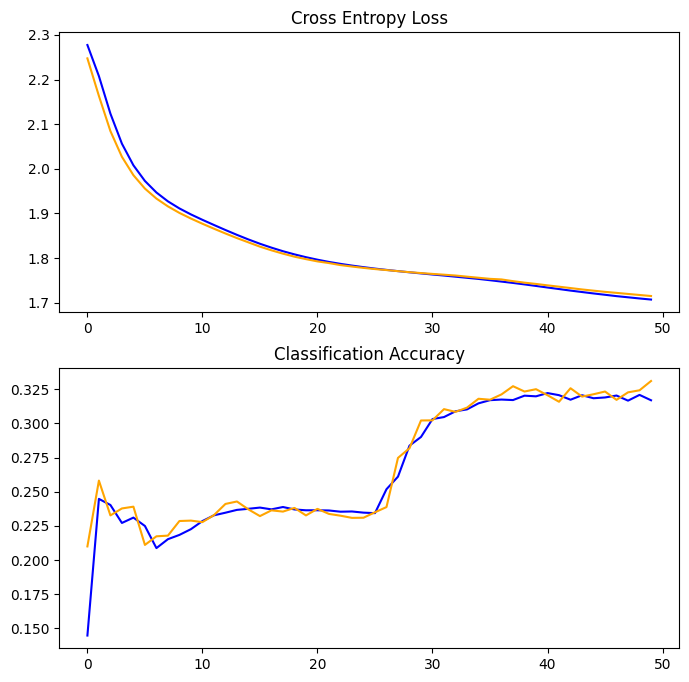

313/313 [==============================] - 0s 1ms/step


<ipython-input-3-158d7bd477a4>:15: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Matriz de confusión normalizada
[[2.602e-01 1.549e-03 2.169e-01 2.388e-01 3.098e-04 1.741e-01 4.647e-03
  1.549e-03 9.820e-02 3.717e-03]
 [1.128e-02 5.634e-01 4.404e-02 2.041e-02 1.504e-02 3.545e-02 1.606e-01
  4.082e-02 9.130e-02 1.772e-02]
 [1.091e-01 3.636e-02 1.091e-01 9.091e-02 0.000e+00 2.000e-01 3.636e-02
  0.000e+00 4.000e-01 1.818e-02]
 [8.917e-02 1.146e-02 1.605e-01 1.554e-01 2.548e-03 2.064e-01 6.242e-02
  1.146e-02 2.943e-01 6.369e-03]
 [4.699e-04 0.000e+00 6.109e-03 1.880e-03 3.492e-01 4.699e-04 4.840e-02
  2.810e-01 4.229e-03 3.083e-01]
 [      nan       nan       nan       nan       nan       nan       nan
        nan       nan       nan]
 [8.621e-03 1.638e-01 2.586e-02 2.586e-02 6.034e-02 4.310e-02 4.397e-01
  1.379e-01 6.034e-02 3.448e-02]
 [3.891e-03 1.868e-02 2.335e-02 7.782e-03 1.556e-01 1.167e-02 2.934e-01
  2.397e-01 2.101e-02 2.249e-01]
 [6.654e-02 4.991e-02 1.331e-01 1.054e-01 1.848e-03 1.294e-01 1.146e-01
  2.957e-02 3.530e-01 1.664e-02]
 [      nan       nan  

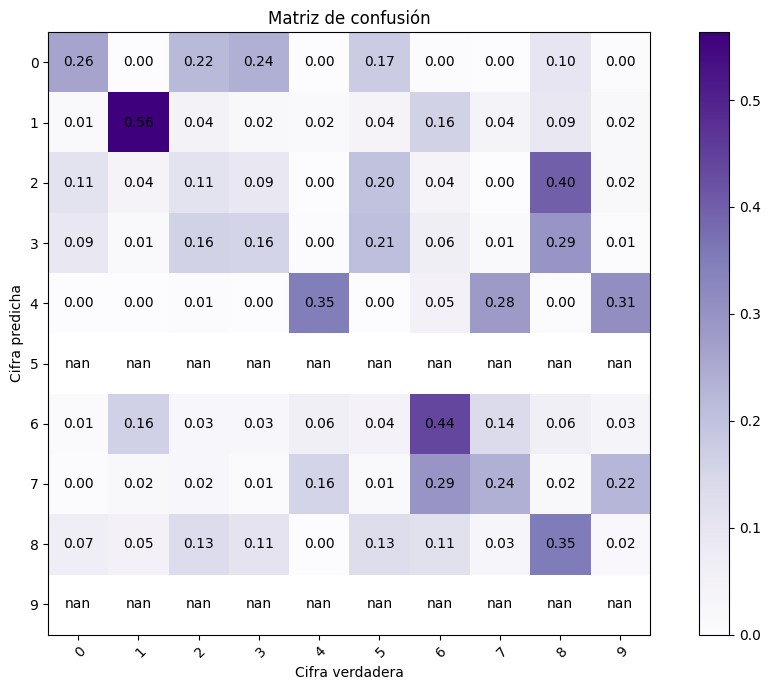

In [17]:
scores, histories, entrenado = evaluar_modelo_simple(trainX, trainY, red_simple,epocas=50)
diagnosticos(histories)
matrizdeconfusion(entrenado,normalizar=True)

Mejoró un poco, no? veo ~29%

Es una sola neurona... con lo más básico de todo... y aún así... vean esa diagonal de la matriz!

In [18]:
def red_simple2():
	model = Sequential()
	model.add(Flatten())
	model.add(Dense(10, activation="sigmoid")) # UNA capa oculta con DIEZ neuronas. Activación más básica que encontramos: Sigmoide.
	model.add(Dense(10, activation='softmax'))
	opt = keras.optimizers.SGD(learning_rate=0.01)
	model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.9262 - accuracy: 0.4969 - val_loss: 1.5595 - val_accuracy: 0.7030
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.3204 - accuracy: 0.7431 - val_loss: 1.0993 - val_accuracy: 0.7844
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.9685 - accuracy: 0.8007 - val_loss: 0.8446 - val_accuracy: 0.8274
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7728 - accuracy: 0.8339 - val_loss: 0.6972 - val_accuracy: 0.8510
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6566 - accuracy: 0.8528 - val_loss: 0.6061 - val_accuracy: 0.8687
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5815 - accuracy: 0.8664 - val_loss: 0.5445 - val_accuracy: 0.8749
Epoch 7/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.5296 - accuracy: 0.8750 - val_loss: 0.5006 - val_accuracy:

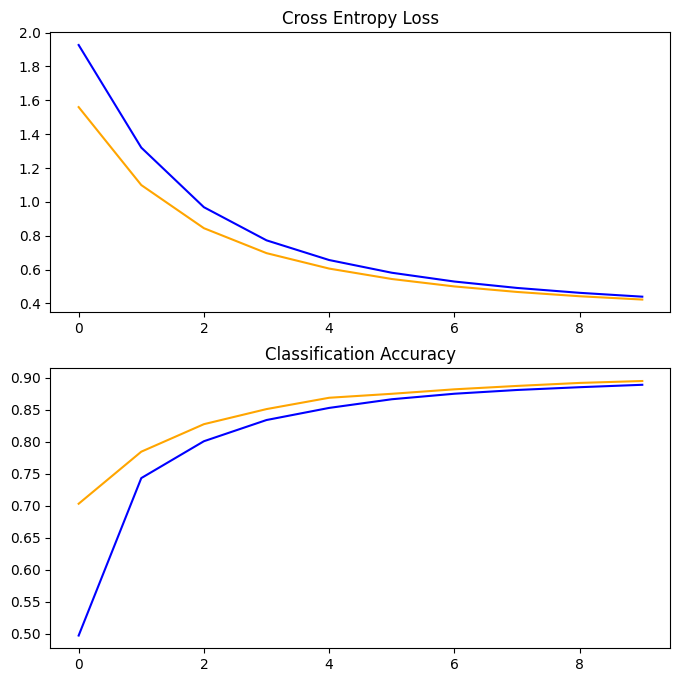

313/313 [==============================] - 0s 1ms/step
Matriz de confusión normalizada
[[9.205e-01 0.000e+00 1.552e-02 1.940e-03 9.699e-04 1.843e-02 1.552e-02
  3.880e-03 7.759e-03 1.552e-02]
 [0.000e+00 9.455e-01 1.107e-02 3.407e-03 8.518e-04 3.407e-03 1.704e-03
  2.044e-02 9.370e-03 4.259e-03]
 [5.929e-03 3.953e-03 8.804e-01 3.854e-02 4.941e-03 4.941e-03 1.186e-02
  2.470e-02 2.075e-02 3.953e-03]
 [4.057e-03 4.057e-03 1.014e-02 8.884e-01 1.014e-03 5.071e-02 0.000e+00
  0.000e+00 3.144e-02 1.014e-02]
 [9.804e-04 0.000e+00 1.961e-02 9.804e-04 8.892e-01 1.078e-02 1.765e-02
  9.804e-03 9.804e-03 4.118e-02]
 [8.168e-03 1.167e-03 0.000e+00 5.134e-02 1.167e-03 8.413e-01 1.984e-02
  2.334e-03 5.951e-02 1.517e-02]
 [8.264e-03 4.132e-03 2.066e-02 1.033e-03 1.550e-02 1.963e-02 9.153e-01
  0.000e+00 1.343e-02 2.066e-03]
 [1.946e-03 1.946e-03 1.654e-02 1.848e-02 1.946e-03 7.782e-03 9.728e-04
  9.047e-01 1.459e-02 3.113e-02]
 [3.191e-03 1.064e-02 4.574e-02 2.021e-02 4.255e-03 4.787e-02 6.383e-03
 

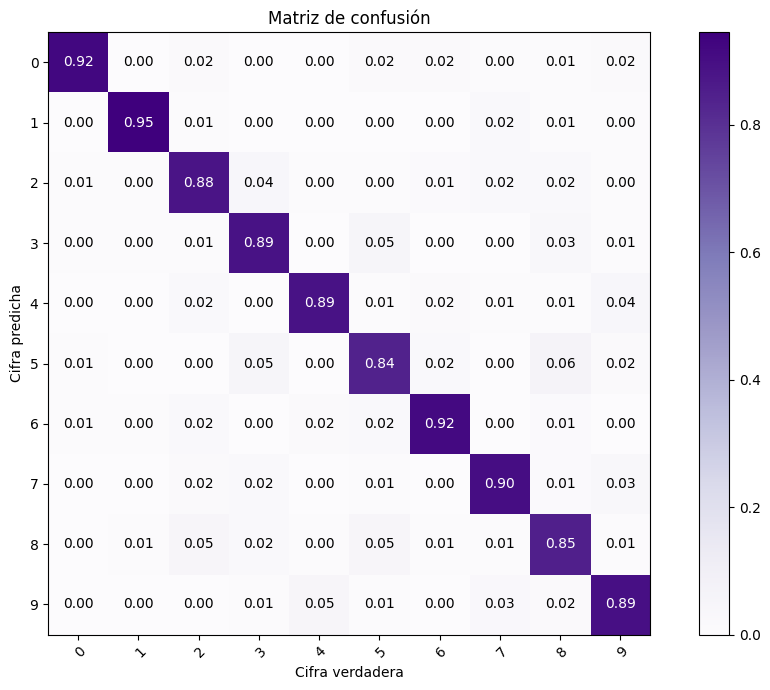

In [19]:
scores, histories, entrenado = evaluar_modelo_simple(trainX, trainY, red_simple2,epocas=10)
diagnosticos(histories)
matrizdeconfusion(entrenado,normalizar=True)


Y si añadimos más capas?

![alt text for screen readers](https://pbs.twimg.com/media/EKaM6e-XUAATeWx.png "Text to show on mouseover")

In [20]:
def red_simple3():
	model = Sequential()
	model.add(Flatten())
	model.add(Dense(50, activation="sigmoid"))
	model.add(Dense(20, activation="sigmoid"))
	model.add(Dense(10, activation='softmax'))
	opt = keras.optimizers.SGD(learning_rate=0.01)
	model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

Epoch 1/50
1875/1875 [==============================] - 5s 2ms/step - loss: 2.2235 - accuracy: 0.3369 - val_loss: 2.1056 - val_accuracy: 0.4956
Epoch 2/50
1875/1875 [==============================] - 5s 2ms/step - loss: 1.8985 - accuracy: 0.5412 - val_loss: 1.6466 - val_accuracy: 0.6114
Epoch 3/50
1875/1875 [==============================] - 5s 3ms/step - loss: 1.4430 - accuracy: 0.6370 - val_loss: 1.2484 - val_accuracy: 0.6791
Epoch 4/50
1875/1875 [==============================] - 4s 2ms/step - loss: 1.1123 - accuracy: 0.7175 - val_loss: 0.9704 - val_accuracy: 0.7567
Epoch 5/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.8766 - accuracy: 0.7820 - val_loss: 0.7742 - val_accuracy: 0.8153
Epoch 6/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.7176 - accuracy: 0.8232 - val_loss: 0.6458 - val_accuracy: 0.8441
Epoch 7/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6132 - accuracy: 0.8481 - val_loss: 0.5614 - val_accuracy:

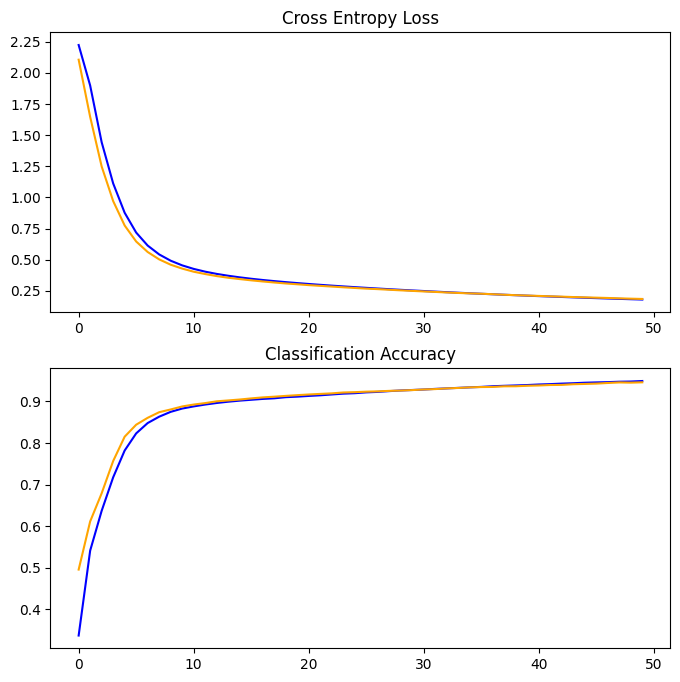

313/313 [==============================] - 1s 2ms/step
Matriz de confusión normalizada
[[9.498e-01 0.000e+00 9.852e-03 9.852e-04 9.852e-04 6.897e-03 1.084e-02
  3.941e-03 4.926e-03 1.182e-02]
 [0.000e+00 9.720e-01 4.378e-03 0.000e+00 1.751e-03 1.751e-03 2.627e-03
  1.051e-02 1.751e-03 5.254e-03]
 [1.938e-03 1.938e-03 9.419e-01 1.453e-02 4.845e-03 9.690e-04 6.783e-03
  2.229e-02 3.876e-03 9.690e-04]
 [9.634e-04 3.854e-03 1.156e-02 9.239e-01 0.000e+00 2.987e-02 1.927e-03
  3.854e-03 1.734e-02 6.744e-03]
 [2.041e-03 1.020e-03 5.102e-03 0.000e+00 9.439e-01 3.061e-03 9.184e-03
  5.102e-03 8.163e-03 2.245e-02]
 [3.505e-03 2.336e-03 0.000e+00 1.402e-02 0.000e+00 9.463e-01 1.285e-02
  0.000e+00 1.519e-02 5.841e-03]
 [3.112e-03 3.112e-03 1.141e-02 1.037e-03 1.037e-02 1.452e-02 9.450e-01
  0.000e+00 1.141e-02 0.000e+00]
 [2.953e-03 2.953e-03 6.890e-03 1.181e-02 1.969e-03 2.953e-03 0.000e+00
  9.508e-01 6.890e-03 1.280e-02]
 [2.092e-03 1.046e-02 9.414e-03 8.368e-03 3.138e-03 1.464e-02 4.184e-03
 

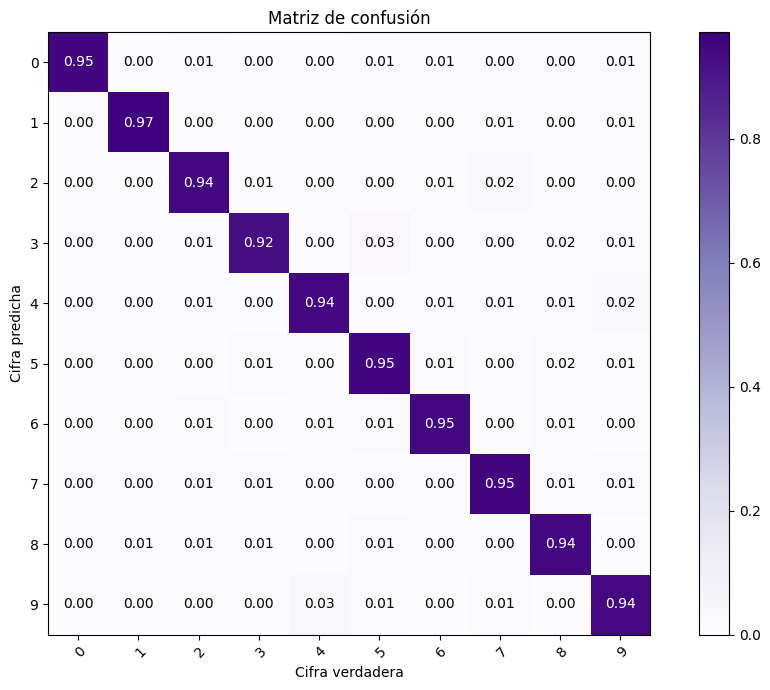

In [21]:
scores, histories, entrenado = evaluar_modelo_simple(trainX, trainY, red_simple3,epocas=50)
diagnosticos(histories)
matrizdeconfusion(entrenado,normalizar=True)

Ahora les toca a ustedes:

-Y si usamos otras funciones de activación? la relu es bastante popular...

-Y si probamos otros optimizadores? Adam y RMSprop son bastante famosos, andarán mejor que el descenso por el gradiente estándar? Otro hiperparámetro para jugar acá: tasa de aprendizaje!

-Estructura de la red: más capas, menos capas, capas más pobladas....

-"Chiches para jugar":

    -Dropout! Desconectemos cosas al azar entre capa y capa!

    -Kfold! Podemos evaluar los modelos haciendo ensambles...

> 24.167
> 25.025
> 20.933
> 21.350
> 23.617


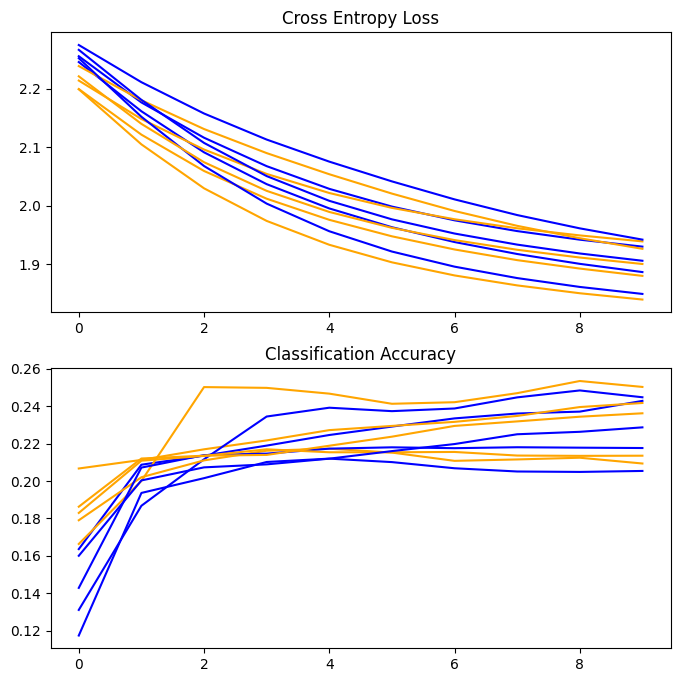

313/313 [==============================] - 0s 1ms/step
Matriz de confusión normalizada
[[0.361 0.002 0.024 0.013 0.008 0.226 0.326 0.003 0.032 0.006]
 [0.001 0.184 0.138 0.128 0.133 0.006 0.002 0.162 0.091 0.154]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [0.006 0.011 0.151 0.162 0.207 0.056 0.045 0.022 0.279 0.061]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [0.042 0.011 0.106 0.169 0.101 0.19  0.079 0.026 0.243 0.032]
 [0.06  0.004 0.075 0.102 0.048 0.346 0.123 0.017 0.212 0.013]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [0.02  0.01  0.093 0.177 0.145 0.129 0.054 0.028 0.284 0.06 ]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]]


<ipython-input-3-158d7bd477a4>:15: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


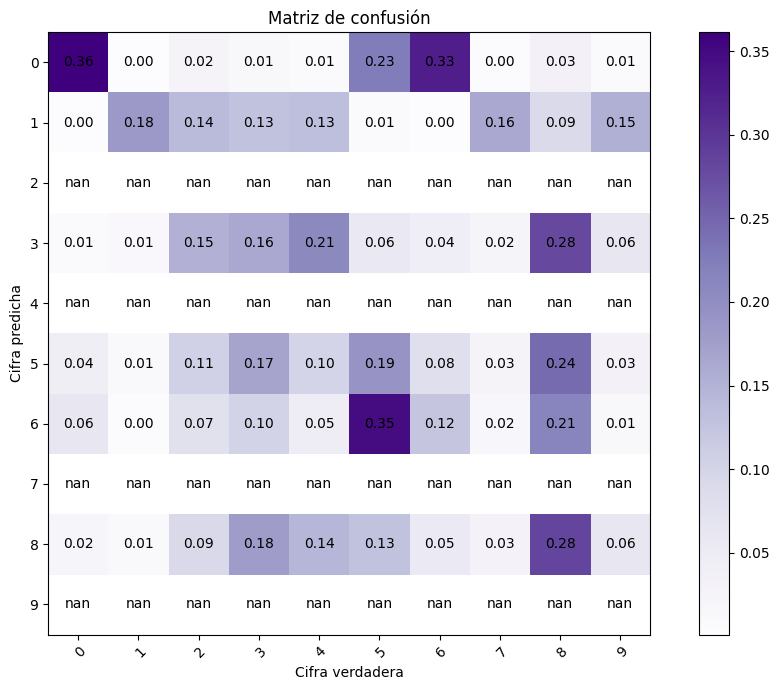

In [22]:
scores, histories, entrenado = evaluar_modelo_kfold(trainX, trainY, red_simple)
diagnosticos(histories)
matrizdeconfusion(entrenado,normalizar=True)

# Código Extra:

In [23]:
halt

NameError: ignored

Aquí les dejo algunas redes extra....

In [ ]:


def red_teo1():
	model = Sequential()
	model.add(Flatten())
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	opt = keras.optimizers.RMSprop(learning_rate=0.003)
	model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

def red_teo2():
	model = Sequential()
	model.add(Flatten())
	model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	opt = keras.optimizers.RMSprop(learning_rate=0.003)
	model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

def red_teo2punto1():
	model = Sequential()
	model.add(Flatten())
	model.add(Dropout(0.0625))
	model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.0625))
	model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	opt = keras.optimizers.Adam(learning_rate=0.002)
	model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model


def red_3():
	model = Sequential()
	model.add(Flatten())
	model.add(Dropout(0.125))
	model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.125))
	model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	opt = keras.optimizers.Adam(learning_rate=0.002)
	model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

Quise graficar varios dígitos a la vez. Al final no lo usé pero me dio cosa borrarlo...

In [ ]:
num = 20
images = trainX[:num]
labels = trainY[:num]

num_row = 4
num_col = 5
# graficar un conjunto
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray_r')
    ax.set_title('Label: {}'.format(np.argmax(labels[i])))
plt.tight_layout()
plt.show()